<a href="https://colab.research.google.com/github/andreac941/ComputerVision-Eq3/blob/main/ImageEnhancing_Eq10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**2.6 Google Colab - Algoritmos de mejoramiento de imágenes basado por pixeles**

**Equipo 10:**
* Carlos Roberto Torres Ferguson A01215432
* Andrea Carolina Treviño Garza A01034993
* Julio Adrián Quintana Gracia A01793661
* Pablo Alejandro Colunga Vázquez A01793671

In [2]:
#Cargar librerías:
import numpy as np
import pandas as pd
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image 
import matplotlib.pylab as plt
import urllib.request

Los ejercicios que deben agregarse a este proyecto serán los siguientes:

**1. Investiga e implementa el método tile-based histogram equalization. En estos métodos, la imagen se particiona en diferentes ventanas (i.e. mosaicos) y los histogramas se calculan de forma independiente, aplicando la corrección sobre cada ventana. Existe un compromiso entre el tamaño de la ventana y la complejidad computacional, por lo cual es más complejo que el método simple. Implementa esta versión y realiza algunas pruebas variando el tamaño de la ventana. Otro inconveniente es que se puede observar posibles diferencias entre los el contraste de los bloques, ¿cómo podría mejorarse?**

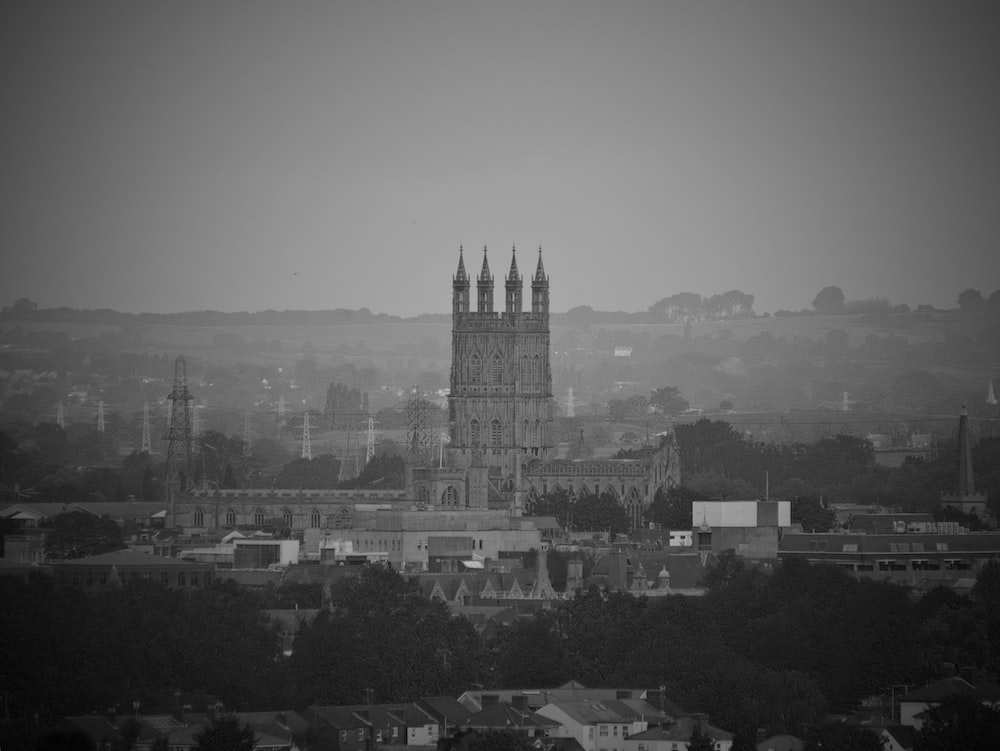

In [3]:
src = io.imread("https://images.unsplash.com/photo-1569722177871-4ed8080b7151?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8Mnx8bG93JTIwY29udHJhc3R8ZW58MHx8MHx8&w=1000&q=80")
src = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
cv2_imshow(src)

In [9]:
# function of histogram equalization
def histeq(im, nbr_bins = 256):
  """ Histogram equalization of a grayscale image.  """
  # get the image histogram
  imhist, bins = np.histogram(im.flatten(), nbr_bins, [0, 256])
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = imhist.max()*cdf/cdf.max()  #normalize
  cdf_mask = np.ma.masked_equal(cdf, 0)
  cdf_mask = (cdf_mask - cdf_mask.min())*255/(cdf_mask.max()-cdf_mask.min())
  cdf = np.ma.filled(cdf_mask,0).astype('uint8')
  return cdf[im.astype('uint8')]

In [10]:
def tile_histeq(img, tile_size=(8,8)):
  # Get image shape
  h, w = img.shape[:2]

  # Get number of tiles in each direction
  n_tiles_x = int(np.ceil(w / tile_size[1]))
  n_tiles_y = int(np.ceil(h / tile_size[0]))

  # Initialize output image
  img_out = np.zeros_like(img)

  # Loop over tiles
  for i in range(n_tiles_y):
    for j in range(n_tiles_x):
      # Get current tile
      x_start = j * tile_size[1]
      y_start = i * tile_size[0]
      x_end = min(x_start + tile_size[1], w)
      y_end = min(y_start + tile_size[0], h)
      tile = img[y_start:y_end, x_start:x_end]

      # Perform histogram equalization on the tile
      hist, bin_edges = np.histogram(tile, bins=256, range=(0, 256))
      cdf = hist.cumsum()
      cdf = 255 * cdf / cdf[-1]
      img_out[y_start:y_end, x_start:x_end] = np.interp(img[y_start:y_end, x_start:x_end], bin_edges[:-1], cdf)
  return img_out

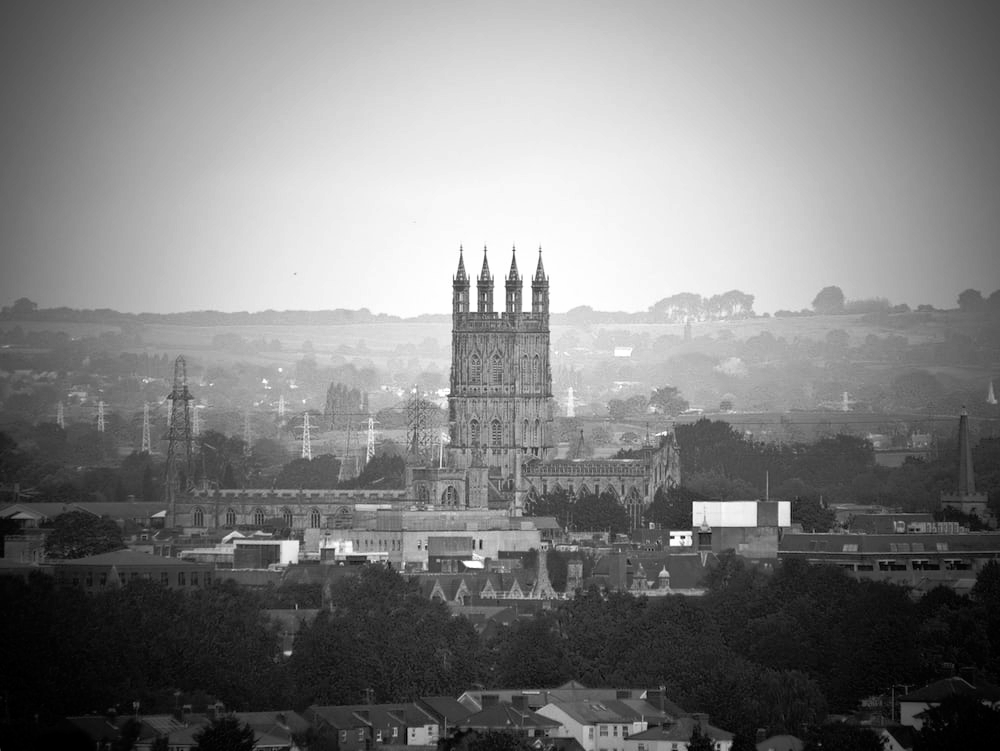

In [16]:
histeq_normal = histeq(src)
cv2_imshow(histeq_normal)

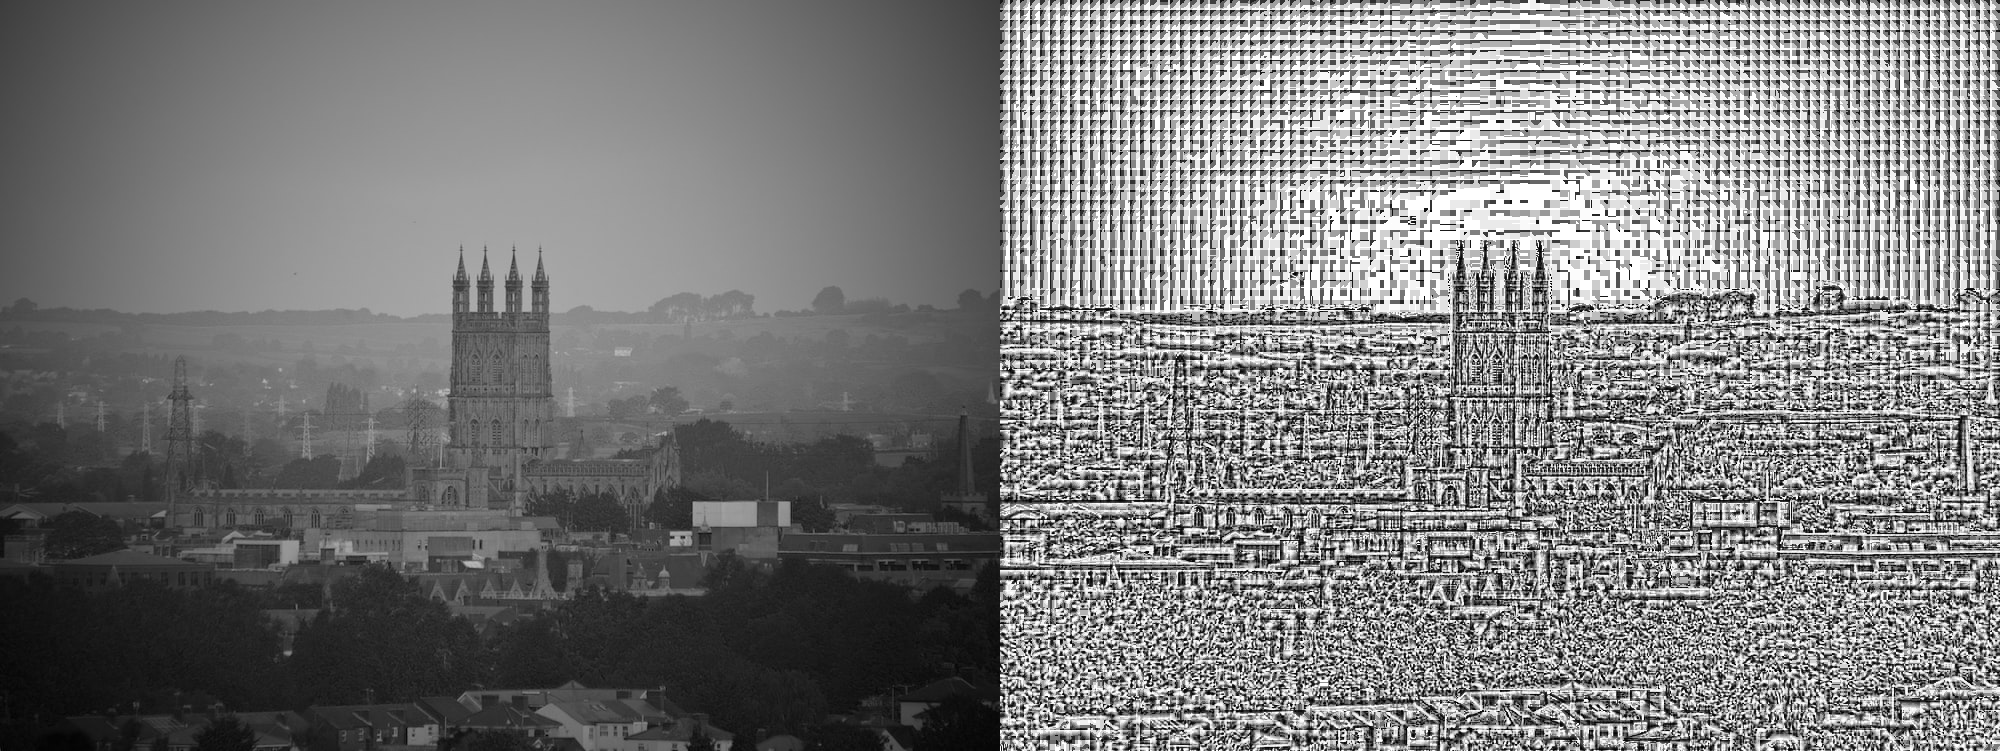

In [11]:
dst_tile_histeq = tile_histeq(src, tile_size=(10, 10))
final_frame = cv.hconcat((src, dst_tile_histeq))
cv2_imshow(final_frame)

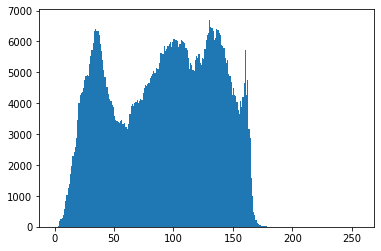

In [6]:
plt.hist(src.ravel(),bins = 256, range = [0, 256])
plt.show()

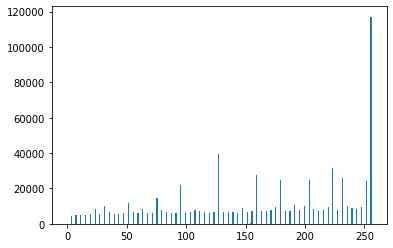

In [7]:
plt.hist(dst_tile_histeq.ravel(),bins = 256, range = [0, 256])
plt.show()

**2. Investiga e implementa un método sencillo del Sliding Window Adaptive Histogram Equalization (SWAHE) y compara algunas imágenes con diferentes tipos de imágenes.**

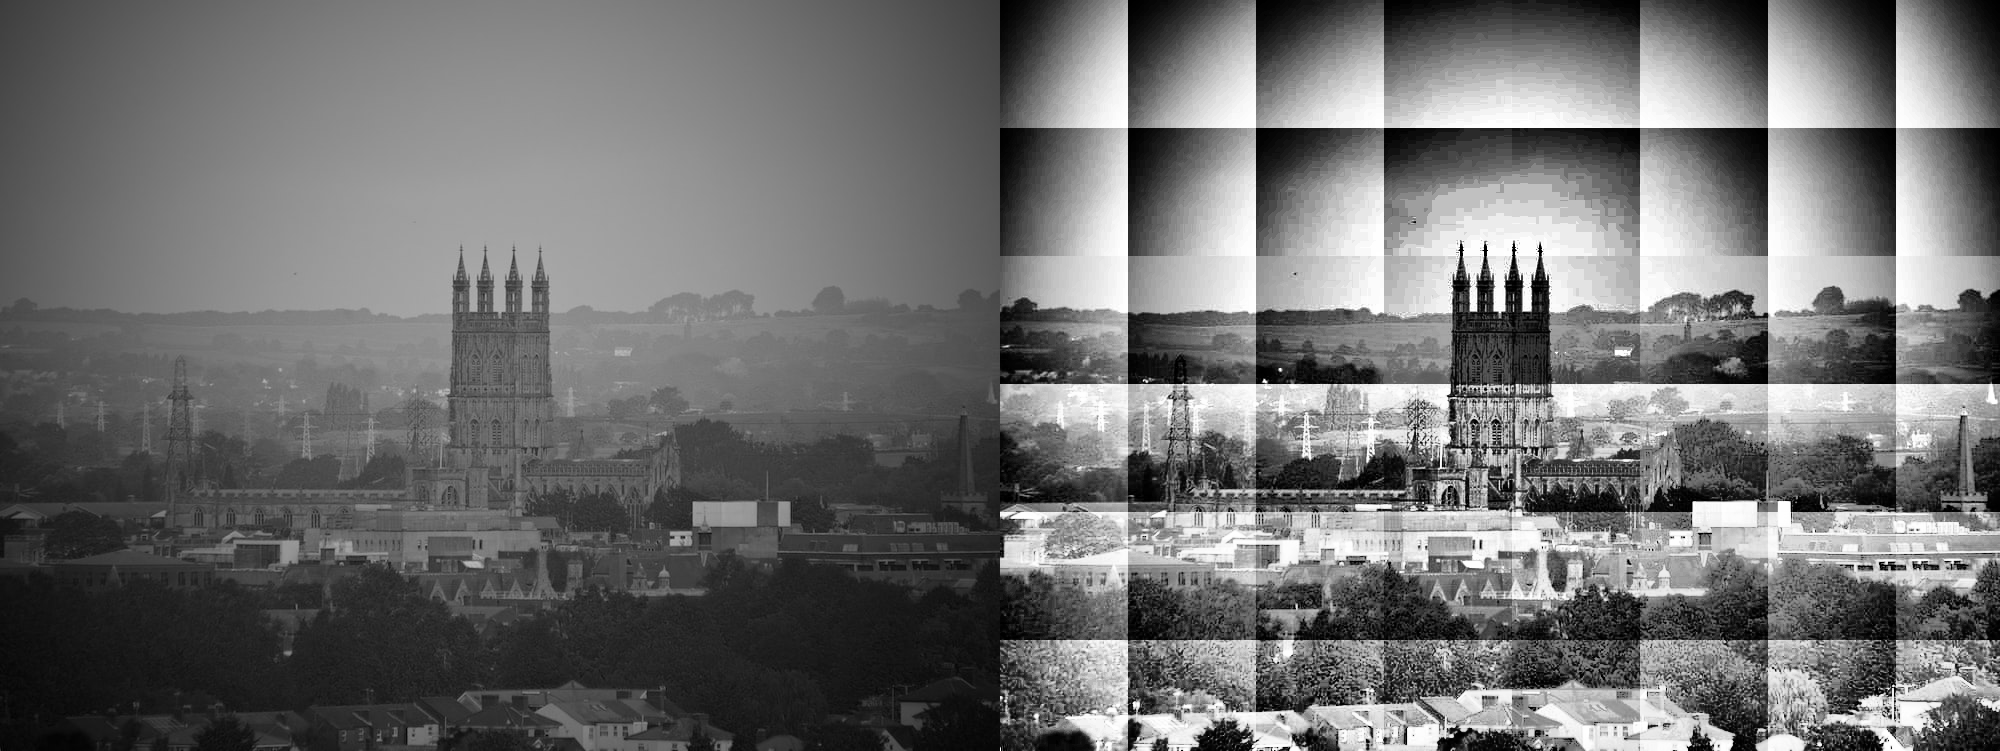

In [12]:
def SWAHE(image, window_size=128, nbr_bins=256):
  rows, cols = image.shape
  window = (window_size, window_size)
  image_swahe = np.zeros_like(image)
  
  for i in range(0, rows, window_size):
    for j in range(0, cols, window_size):
      window_image = image[i:i + window[0], j:j+window[1]]
      imhist, bins = np.histogram(window_image.flatten(), nbr_bins, [0, 256])
      cdf = imhist.cumsum()
      cdf_mask = np.ma.masked_equal(cdf, 0)
      cdf_mask = (cdf_mask - cdf.min()) * 255 / (cdf_mask.max() - cdf_mask.min())
      cdf = np.ma.filled(cdf_mask,0).astype('uint8')
      window_image = cdf[window_image]
      image_swahe[i:i+window[0], j:j+window[1]] = window_image
  return image_swahe

dst_swahe = SWAHE(src, window_size=128)
final_frame = cv.hconcat((src, dst_swahe))
cv2_imshow(final_frame)

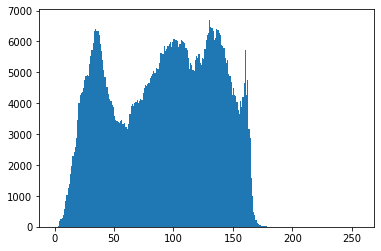

In [13]:
plt.hist(src.ravel(),bins = 256, range = [0, 256])
plt.show()

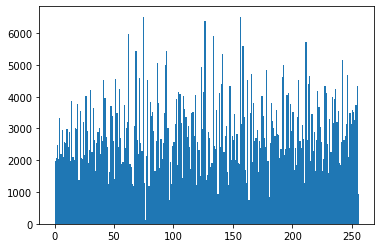

In [14]:
plt.hist(dst_swahe.ravel(),bins = 256, range = [0, 256])
plt.show()

**3. Investiga cómo funciona el algoritmo CLAHE (contrast limited adaptive histogram equalization) y realiza una implementación (puede ser usando la implementación de OpenCV). Prueba sobre diferentes tipos de imágenes y compara con el método de ecualización de histogramas básico. Provee una breve descripción del método a partir de una  investigación bibliográfica.**

In [17]:
def CLAHE(img, clip_limit=2.0, tile_size=(8,8)):
    # Get image shape
    h, w = img.shape[:2]

    # Get number of tiles in each direction
    n_tiles_x = int(np.ceil(w / tile_size[1]))
    n_tiles_y = int(np.ceil(h / tile_size[0]))

    # Initialize output image
    img_out = np.zeros_like(img)

    # Loop over tiles
    for i in range(n_tiles_y):
        for j in range(n_tiles_x):
            # Get current tile
            x_start = j * tile_size[1]
            y_start = i * tile_size[0]
            x_end = min(x_start + tile_size[1], w)
            y_end = min(y_start + tile_size[0], h)
            tile = img[y_start:y_end, x_start:x_end]

            # Perform histogram equalization on the tile
            hist, bin_edges = np.histogram(tile, bins=256, range=(0, 256))
            cdf = hist.cumsum()
            cdf = 255 * cdf / cdf[-1]

            # Clip the histogram and redistribute the excess mass
            hist_clip = np.minimum(hist, clip_limit * np.amax(hist))
            cdf_clip = hist_clip.cumsum()
            cdf_clip = 255 * cdf_clip / cdf_clip[-1]

            img_out[y_start:y_end, x_start:x_end] = np.interp(img[y_start:y_end, x_start:x_end], bin_edges[:-1], cdf_clip)

    return img_out

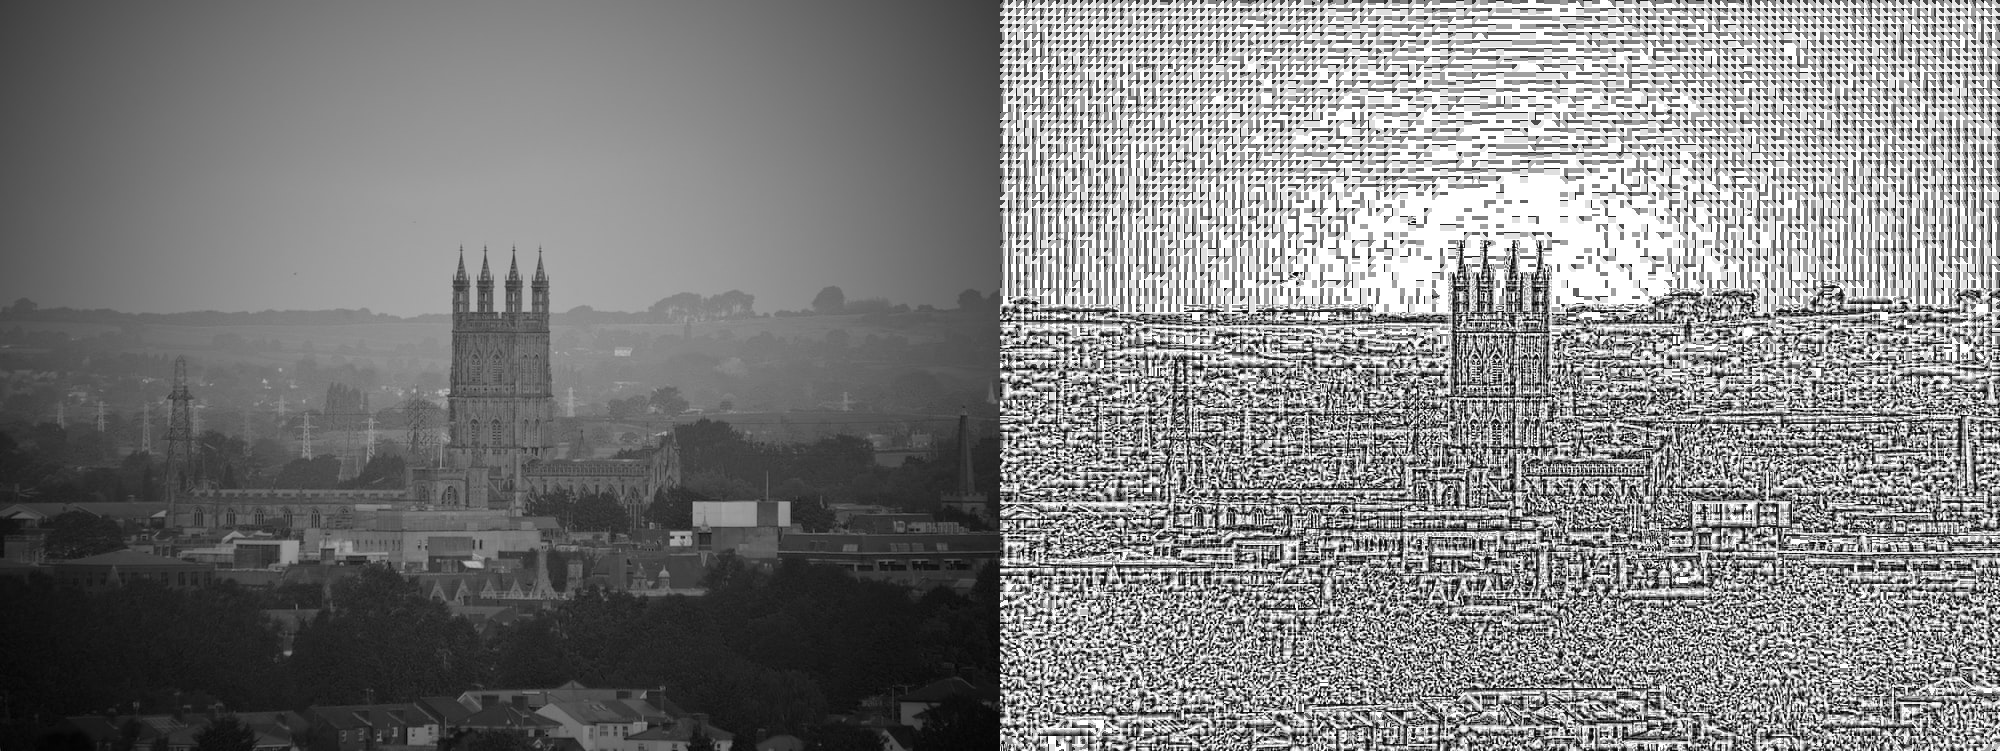

In [18]:
dst_clahe = CLAHE(src)
final_frame = cv.hconcat((src, dst_clahe))
cv2_imshow(final_frame)

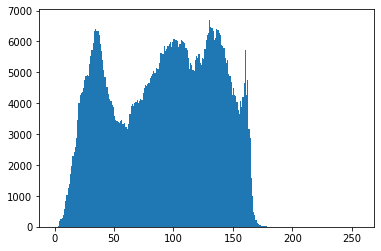

In [19]:
plt.hist(src.ravel(),bins = 256, range = [0, 256])
plt.show()

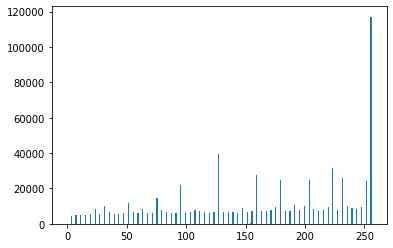

In [20]:
plt.hist(dst_clahe.ravel(),bins = 256, range = [0, 256])
plt.show()

#**Referencias**
* 